<a href="https://colab.research.google.com/github/Aryan-del360/Trader-Behavior-Market-Sentiment-Analysis/blob/main/Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Load Datasets**

In [90]:
traders_data_path = '/content/ds_Shubham/csv_files/historical_data.csv'
sentiment_data_path = '/content/ds_Shubham/csv_files/fear_greed_index.csv'

In [91]:
traders_df = pd.read_csv(traders_data_path)
sentiment_df = pd.read_csv(sentiment_data_path)

print("Traders data shape:", traders_df.shape)
print("Sentiment data shape:", sentiment_df.shape)

Traders data shape: (211224, 16)
Sentiment data shape: (2644, 4)


In [92]:
print(traders_df.head())
print(sentiment_df.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

**Clean column names**

In [93]:
traders_df.columns =  traders_df.columns.str.strip().str.lower().str.replace(' ', '_')
sentiment_df.columns =  sentiment_df.columns.str.strip().str.lower().str.replace(' ', '_')

**Parse** **dates**

In [94]:
traders_df['timestamp_ist'] = pd.to_datetime(traders_df['timestamp_ist'], errors='coerce')
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

In [95]:
traders_df['date'] = traders_df['timestamp_ist'].dt.date
sentiment_df['date'] = sentiment_df['date'].dt.date

**Convert numeric fields**

In [96]:
for col in ["execution_price", "size_tokens", "size_usd", "closed_pnl", "fee"]:
  if col in traders_df.columns:
    traders_df[col] = pd.to_numeric(traders_df[col], errors='coerce')

**Daily aggregation**

In [97]:
daily_trades = traders_df.groupby("date").agg(
    total_trades = ("account", "count"),
    total_volume_usd = ("size_usd", "sum"),
    avg_execution_price=("execution_price", "mean"),
    median_pnl=("closed_pnl", "median"),
    win_rate=("closed_pnl", lambda x: (x > 0).mean())
).reset_index()

**Merge with sentiment data**

In [98]:
merged = pd.merge(daily_trades, sentiment_df[["date", "classification", "value"]], on="date", how="left")

**Save processed dataset**

In [99]:
merged.to_csv("/content/ds_Shubham/csv_files/daily_trades_merged.csv", index=False)
print("Saved daily_trades_merged.csv")

Saved daily_trades_merged.csv


**Quick EDA**

In [100]:
print(merged.head())

         date  total_trades  total_volume_usd  avg_execution_price  \
0  2023-01-05             3            477.00          1898.133333   
1  2023-05-12             9          50005.83         11038.300000   
2  2024-01-01            18         264239.53         10373.330667   
3  2024-01-02             6           2008.18             0.076126   
4  2024-01-03           137         472974.70             2.725657   

   median_pnl  win_rate classification  value  
0     0.00000  0.000000           Fear   29.0  
1     0.00000  0.000000        Neutral   49.0  
2     0.00000  0.055556          Greed   65.0  
3     0.00000  0.000000          Greed   71.0  
4    27.04384  0.934307          Greed   70.0  


**Daily Volume Plot**

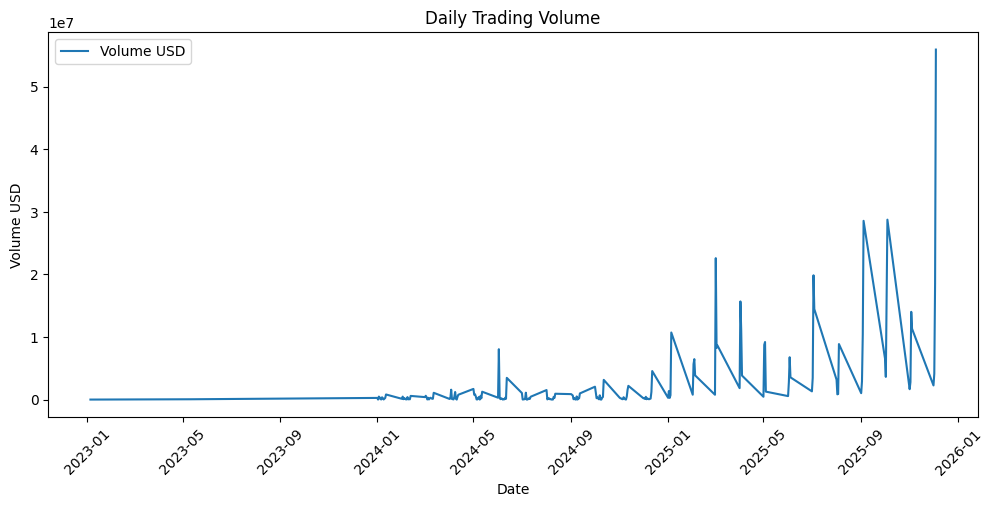

In [101]:
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(merged["date"]), merged["total_volume_usd"], label="Volume USD")
plt.title("Daily Trading Volume")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Volume USD")
plt.legend()
plt.savefig("/content/ds_Shubham/outputs/volume_trend.png")
plt.show()

**Analysis and insights**

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr

**1. Load processed dataset**

In [103]:
merged = pd.read_csv("/content/ds_Shubham/csv_files/daily_trades_merged.csv")
merged["date"] = pd.to_datetime(merged["date"])

**2. Compare Fear vs Greed**

In [104]:
grouped = merged.groupby("classification").agg(
    mean_volume=("total_volume_usd","mean"),
    mean_pnl=("median_pnl","mean"),
    mean_win_rate=("win_rate","mean")
).reset_index()
print(grouped)

  classification   mean_volume  mean_pnl  mean_win_rate
0   Extreme Fear  1.596707e+06  6.194051       0.307500
1  Extreme Greed  4.238084e+05  6.614152       0.319642
2           Fear  2.153362e+06  3.492764       0.348071
3          Greed  1.018675e+06  3.594410       0.362415
4        Neutral  7.462220e+05  4.213464       0.286719



**3. Boxplot of PnL by Sentiment**

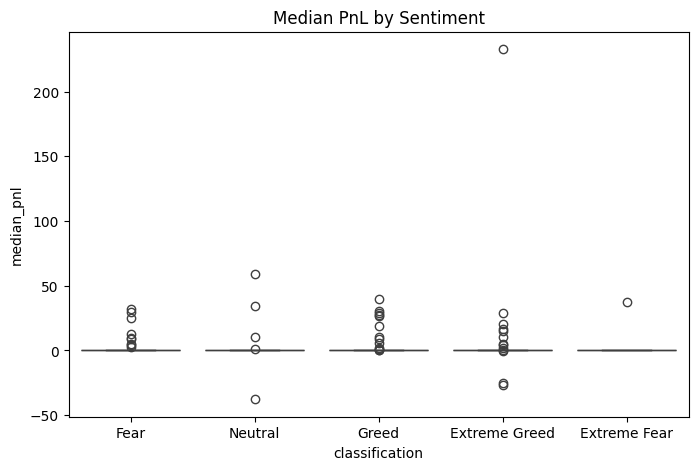

In [105]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x="classification", y="median_pnl")
plt.title("Median PnL by Sentiment")
plt.savefig("/content/ds_Shubham/outputs/pnl_by_sentiment.png")
plt.show()


**4. Statistical Test: Volume in Fear vs Greed**

In [106]:
fear = merged[merged["classification"].str.contains("Fear", na=False)]["total_volume_usd"].dropna()
greed = merged[merged["classification"].str.contains("Greed", na=False)]["total_volume_usd"].dropna()

# Use non-parametric if distributions are skewed
if len(fear) > 0 and len(greed) > 0:
    stat, p = mannwhitneyu(fear, greed)
    print("Mann-Whitney U test on Volume: stat=%.3f, p=%.3f" % (stat, p))

Mann-Whitney U test on Volume: stat=2352.000, p=0.322


**5. Correlation: Fear-Greed Index vs Trading Volume**

In [107]:
# Drop rows with any missing values in the relevant columns before calculating correlation
cleaned_merged = merged.dropna(subset=["value", "total_volume_usd"])
corr, p = pearsonr(cleaned_merged["value"], cleaned_merged["total_volume_usd"])
print(f"Correlation (Fear-Greed Index vs Volume): {corr:.3f}, p={p:.3f}")

Correlation (Fear-Greed Index vs Volume): -0.188, p=0.018


**6. Lineplot: Sentiment vs Volume**

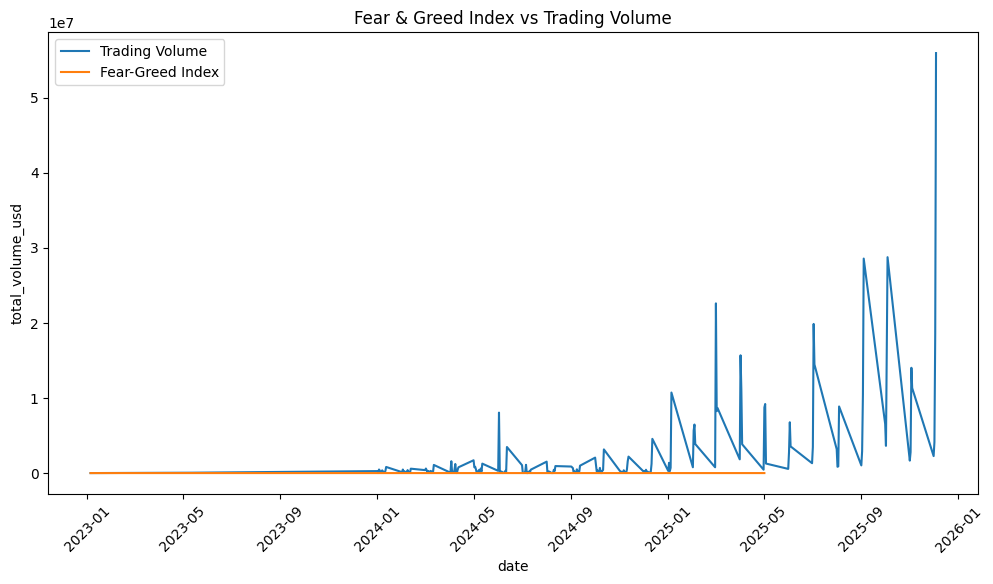

In [108]:
plt.figure(figsize=(12,6))
sns.lineplot(x="date", y="total_volume_usd", data=merged, label="Trading Volume")
sns.lineplot(x="date", y="value", data=merged, label="Fear-Greed Index")
plt.title("Fear & Greed Index vs Trading Volume")
plt.xticks(rotation=45)
plt.legend()
plt.savefig("/content/fear_greed_vs_volume.png")
plt.show()